### Wang Scheme

Do not start more than 20 processes! The job will just hang.

In [1]:
# All samples (190119664): 5.5s per entry of the tensor

In [2]:
import os
import gc
import sys
import time
import numpy as np
import datetime
import matplotlib
import matplotlib.pyplot as plt

sys.path.insert(0, '~/workspace_icon-ml/symbolic_regression/')
from functions import evaluate_sundqvist

# Shall we use the tuned hyperparameters?
tuned = False

# Added to the PDF name
hour_min = '%d_%d'%(datetime.datetime.now().hour, datetime.datetime.now().minute)

matplotlib.use('PDF')
output_var = sys.argv[1] 

In [3]:
output_var = 'cl_volume'

In [4]:
# Load columns of data
folder_data = '~/my_work/icon-ml_data/cloud_cover_parameterization/neighborhood_based_SR_DYAMOND/'

input_data = np.load(os.path.join(folder_data, 'cloud_cover_input_dyamond.npy'))
if output_var == 'cl_volume':
    output_data = np.load(os.path.join(folder_data, 'cloud_cover_output_dyamond.npy'))
elif output_var == 'cl_area':
    output_data = np.load(os.path.join(folder_data, 'cloud_area_output_dyamond.npy'))

new_features = ['hus', 'clw', 'cli', 'ta', 'pa', 'zg', 'fr_land', 'U', 'rh', 'ps', 'hus_z', 'hus_zz', 'clw_z', 'clw_zz', 'cli_z',\
                'cli_zz', 'ta_z', 'ta_zz', 'pa_z', 'pa_zz', 'U_z', 'U_zz', 'rh_z', 'rh_zz']

In [5]:
samples_total, no_of_features = input_data.shape

# Split into train/valid
training_folds = []
validation_folds = []
two_week_incr = samples_total//6

for i in range(3):
    # Note that this is a temporal split since time was the first dimension in the original tensor
    first_incr = np.arange(samples_total//6*i, samples_total//6*(i+1))
    second_incr = np.arange(samples_total//6*(i+3), samples_total//6*(i+4))

    validation_folds.append(np.append(first_incr, second_incr))
    training_folds.append(np.arange(samples_total))
    training_folds[i] = np.delete(training_folds[i], validation_folds[i])

# The second fold yields the best model
input_train = input_data[training_folds[1]]
input_valid = input_data[validation_folds[1]]
output_train = output_data[training_folds[1]]
output_valid = output_data[validation_folds[1]]

# Remove input_data, output_data
del input_data, output_data, training_folds, validation_folds
gc.collect()

42

In [6]:
# To locate variables
loc = {}
for i in range(len(new_features)):
    loc[new_features[i]] = i
    
input_train.shape

(190119664, 24)

In [7]:
# # First try (20/400):
# par_range = np.linspace(0.05, 1, 20)
# alpha_range = np.linspace(20, 200, 400)

# # Second try
# par_range = np.linspace(0.01, 0.4, 20)
# alpha_range = np.linspace(1000, 200000, 400)

# # Third try
# par_range = np.linspace(0.35, 0.8, 20)
# alpha_range = np.linspace(80000, 400000, 400)

# Forth try
par_range = np.linspace(0.7, 1.2, 20)
alpha_range = np.linspace(120000, 1000000, 400)

In [8]:
# Estimated required time to run the notebook in hours
# Factor of 5 instead of len(par_range) due to multiprocessing
print('Estimated required time to run the notebook: %.1f hours'%((5.5*(5*len(alpha_range)))/3600))

Estimated required time to run the notebook: 3.1 hours


In [10]:
def search_hyperparams_outer(par):
    return search_hyperparams_inner(par, alpha_range)

In [11]:
from contextlib import contextmanager
import multiprocessing as mlp
import gc

@contextmanager
def poolcontext(*args, **kwargs):
    pool = mlp.Pool(*args, **kwargs)
    yield pool
    pool.terminate()

In [12]:
def search_hyperparams_inner(par, alpha_range):
    mse_tensor = -np.ones((1, len(alpha_range)))
    i2 = -1
    for alpha in alpha_range:
        i2 += 1
        
        # What is the average error with this set of tuning parameters?
        clw = input_train[:, loc['clw']]
        cli = input_train[:, loc['cli']]
        r = input_train[:, loc['rh']]

        c = r**par*(1-np.exp(-alpha*(cli+clw)))
        
        # c can exceed 1 very slightly
        c = np.minimum(c, 1)

        mse_tensor[0, i2] = np.mean((100*c - output_train)**2)
                    
    return mse_tensor

### Fitting hyperparameters
Originally: $p = 0.25, \alpha = 10^5$ (Note that in Wang the cloud condensates are given in g/kg!)

In [13]:
t0 = time.time()

In [ ]:
procs = len(par_range)
with poolcontext(processes=procs) as pool:
    # Every process received a part of data_dict
    mse_tensor = pool.map(search_hyperparams_outer, par_range)
    
mse_tensor = np.squeeze(np.array(mse_tensor))
                
# assert np.all(mse_tensor >= 0)
np.save('~/workspace_icon-ml/symbolic_regression/baselines/wang_tuning_dyamond/mse_tensor_%s.npy'%hour_min, mse_tensor)

Process ForkPoolWorker-51:
Process ForkPoolWorker-56:
Process ForkPoolWorker-23:
Process ForkPoolWorker-97:
Process ForkPoolWorker-71:
Process ForkPoolWorker-19:
Process ForkPoolWorker-134:
Process ForkPoolWorker-102:
Process ForkPoolWorker-91:
Process ForkPoolWorker-95:
Process ForkPoolWorker-106:
Process ForkPoolWorker-124:
Process ForkPoolWorker-52:
Process ForkPoolWorker-111:
Process ForkPoolWorker-73:
Process ForkPoolWorker-65:
Process ForkPoolWorker-83:
Process ForkPoolWorker-117:
Process ForkPoolWorker-110:
Process ForkPoolWorker-89:
Process ForkPoolWorker-104:
Process ForkPoolWorker-7:
Process ForkPoolWorker-9:
Process ForkPoolWorker-31:
Process ForkPoolWorker-45:
Process ForkPoolWorker-14:
Process ForkPoolWorker-123:
Process ForkPoolWorker-103:
Process ForkPoolWorker-100:
Process ForkPoolWorker-101:
Process ForkPoolWorker-68:
Process ForkPoolWorker-39:
Process ForkPoolWorker-66:
Process ForkPoolWorker-44:
Process ForkPoolWorker-85:
Process ForkPoolWorker-3:
Process ForkPoolWor

In [ ]:
min_mse = 10**10
for i in range(mse_tensor.shape[0]):
    for j in range(mse_tensor.shape[1]):
        if mse_tensor[i,j] < min_mse:
            min_mse = mse_tensor[i,j]
            opt_ind = [i,j]                  
                    
with open('~/workspace_icon-ml/symbolic_regression/baselines/wang_tuning_dyamond/best_results.txt', 'a') as file:
    file.write('Time it took: %.3f\n'%(time.time() - t0))
    file.write('Output variable: %s\n'%output_var)
    file.write('Best values: %s\n'%str([par_range[opt_ind[0]], alpha_range[opt_ind[1]]]))

### Plotting the results (To run)

3626.6205753929526


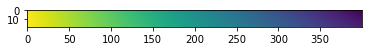

In [2]:
# import numpy as np
# import matplotlib.pyplot as plt

# mse_tensor = np.load('~/workspace_icon-ml/symbolic_regression/baselines/wang_tuning_dyamond/mse_tensor_9_42.npy')
# plt.imshow(mse_tensor)
# print(np.min(mse_tensor))

805.7359884400947


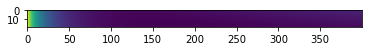

In [4]:
# import numpy as np
# import matplotlib.pyplot as plt

# mse_tensor = np.load('~/workspace_icon-ml/symbolic_regression/baselines/wang_tuning_dyamond/mse_tensor_10_2.npy')
# plt.imshow(mse_tensor)
# print(np.min(mse_tensor))

777.0401394844681


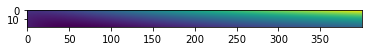

In [6]:
import numpy as np
import matplotlib.pyplot as plt

mse_tensor = np.load('~/workspace_icon-ml/symbolic_regression/baselines/wang_tuning_dyamond/mse_tensor_12_53.npy')
plt.imshow(mse_tensor)
print(np.min(mse_tensor))

### Performance with the best hyperparameter setting (To run)

In [13]:
def wang_eval(input_data, output_data, loc, par, alpha):
    # What is the average error with this set of tuning parameters?
    clw = input_data[:, loc['clw']]
    cli = input_data[:, loc['cli']]
    r = input_data[:, loc['rh']]

    c = r**par*(1-np.exp(-alpha*(cli+clw)))

    # c can exceed 1 very slightly
    c = np.minimum(c, 1)

    mse = np.mean((100*c - output_data)**2)
    var = np.var(output_data)
    r2 = 1-mse/var
    
    return mse, r2

In [14]:
if output_var == 'cl_volume':
    par_opt = 1.2
    alpha_opt = 172932.3308
elif output_var == 'cl_area':
    par_opt = 0.9105
    alpha_opt = 913984.9624

In [15]:
mse_train, r2_train = wang_eval(input_train, output_train, loc, par_opt, alpha_opt)
mse_valid, r2_valid = wang_eval(input_valid, output_valid, loc, par_opt, alpha_opt)

In [16]:
with open('~/workspace_icon-ml/symbolic_regression/baselines/wang_tuning_dyamond/best_results.txt', 'a') as file:
    file.write('Output variable: %s\n'%output_var)
    file.write('Training score:\n')
    file.write('MSE: %.3f, R2: %.3f\n'%(mse_train, r2_train))
    file.write('Validation score:\n')
    file.write('MSE: %.3f, R2: %.3f\n\n'%(mse_valid, r2_valid))